In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Ingestion Pipeline

In [2]:
wait_flag = False
# df = pd.read_parquet(f"../py_sim_output_w_{wait_flag}.parquet")
df = pd.read_parquet(f"../../test.parquet")
df.head()

,s_val,age_at_ref,ref_epoch,ax_epoch,n_appts,pct_face,dis_epoch,age_out,wlist_flush
0,1,87.354098,0,0.0,7.240000,0.0,28,False,False
1,1,94.093595,0,1.0,7.270038,0.0,28,False,False
2,1,52.233836,0,2.0,7.300077,0.0,28,False,False
3,1,27.557629,0,3.0,7.330115,0.0,29,False,False
4,1,117.547238,1,1.0,7.240000,0.0,29,False,False


Conduct some data processing:
1. Get the tiem from referral to assessment in weeks and years
2. Get ages in years


In [3]:
df['ref_to_ax_yrs'] = (df['ax_epoch'] - df['ref_epoch'])/52
df['age_at_ref_yrs'] = df['age_at_ref']/52
df['age_at_discharge_yrs'] = (df['dis_epoch'] - df['ref_epoch'])/52 + df['age_at_ref_yrs']

Text(0.5, 0, 'Discharge epoch (Week)')

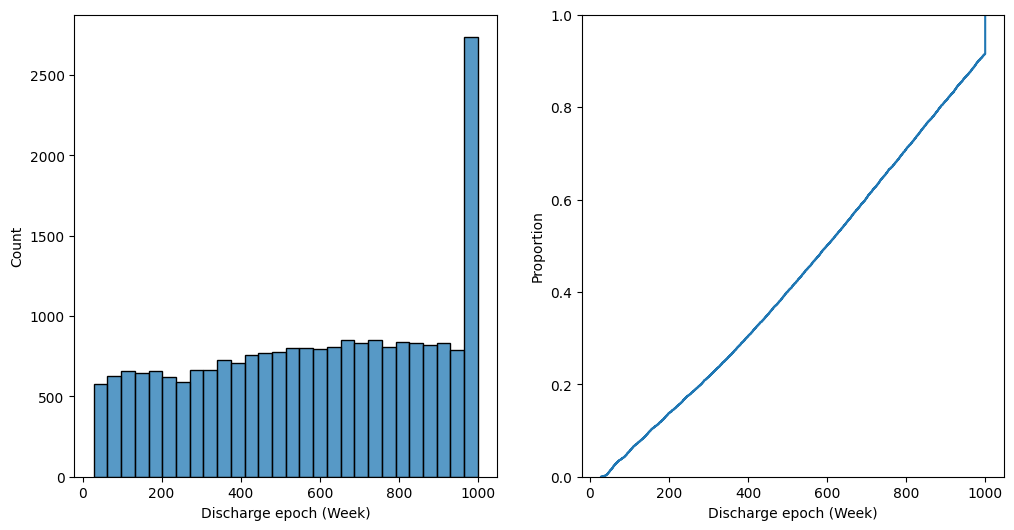

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(df['dis_epoch'], ax=ax[0])
ax[0].set_xlabel("Discharge epoch (Week)")
sns.ecdfplot(data=df, x='dis_epoch', stat='proportion', ax=ax[1])
ax[1].set_xlabel("Discharge epoch (Week)")

Truncate the data to after the 20th percentile of the discharge epoch (i.e., 'burn-in' the simulation). Consider the 20th percentile of the patients who were discharged from service (as opposed to flushed from the waitlist at the termination of the simulation).

In [5]:
df = df.loc[df['dis_epoch'] >= np.percentile(df.loc[df['wlist_flush']==False, 'dis_epoch'], 20)].copy()

Report the statistics for all patients (i.e., those who entered service and those who were flushed from the waitlist), the statistics for only those who entered service, and the statistics for only those who were flushed from the waitlist.

In [6]:
print("The discharge and age-out statistics for all patients:")
temp = df.age_out.value_counts(normalize=True)
print(f"{temp[False]*100:.3f}% of patients who left the system were discharged for acheiving approporiate outcomes.")
print(f"{temp[True]*100:.3f}% of patients who left the system were discharged for aging-out.")

The discharge and age-out statistics for all patients:
61.865% of patients who left the system were discharged for acheiving approporiate outcomes.
38.135% of patients who left the system were discharged for aging-out.


In [7]:
df.groupby('s_val', as_index=False).agg({'age_out': lambda x: x.sum()/x.count(),
                                         'age_at_ref_yrs': 'mean',
                                         'age_at_discharge_yrs': 'mean'})

,s_val,age_out,age_at_ref_yrs,age_at_discharge_yrs
0,1,0.312769,1.765538,3.713217
1,2,0.395580,1.762457,3.830850
2,3,0.402808,1.755169,3.838825


In [8]:
print(f"The average wait time for patients served was {df.loc[df['wlist_flush']==False, 'ref_to_ax_yrs'].mean():.2f} years.")
print(f"The average wait time by category was:")
print(df.loc[df['wlist_flush']==False].groupby('s_val', as_index=False).agg({'ref_to_ax_yrs': 'mean'}))
print(f"The average age-out ratio for patients served was:")
print(df.loc[df['wlist_flush']==False].groupby('s_val', as_index=False).agg({'age_out': 'mean'}))

The average wait time for patients served was 1.55 years.
The average wait time by category was:
   s_val  ref_to_ax_yrs
0      1       1.560421
1      2       1.550781
2      3       1.550908
The average age-out ratio for patients served was:
   s_val   age_out
0      1  0.308951
1      2  0.392336
2      3  0.399522


Report the waitlist statistics at the end of the simulation.

In [9]:
temp = df.loc[df['wlist_flush']==True]
print(f"There were {temp.shape[0]} patients who were flushed from the waitlist.")
print(f"Among them, {temp.age_out.sum()} patients aged-out.")
print(f"The average waiting time of patients on the waitlist was {(temp['dis_epoch'] - temp['ref_epoch']).mean()/52:.2f} years.")
print(f"The number of patients of each class still on the waitlist at the end of the simulation:")
print(temp.groupby('s_val', as_index=False).size())

There were 1941 patients who were flushed from the waitlist.
Among them, 91 patients aged-out.
The average waiting time of patients on the waitlist was 0.83 years.
The number of patients of each class still on the waitlist at the end of the simulation:
   s_val  size
0      1   376
1      2  1075
2      3   490
